In [30]:
import os
import NN
import utils
from torch import save as save_model
from torch import load as load_model
import config as cfg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils import mean_absolute_percentage_error, theilU
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

## Train and Evaluate a single model

### Setup Parameters

In [2]:
ETF = 'DIA' # 'SPY', 'DIA', 'QQQ'
NNtype = 'MLP' # 'MLP', 'RNN', 'PSN'
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype] # SPYfeatures, DIAfeatures, QQQfeatures

### Load Dataframes

In [3]:
traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

### Initialize DataLoaders

In [4]:
features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'


if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

### Instanciate Model

In [5]:
model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500

model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)


### Training

In [6]:
model.train(trainloader, validloader)

[00:00] Epoch 1/500 - Train Loss : 1.047184 / Val Loss : 1.001686
[00:37] Epoch 100/500 - Train Loss : 0.954827 / Val Loss : 1.015512
[01:15] Epoch 200/500 - Train Loss : 0.857422 / Val Loss : 1.035131
[01:53] Epoch 300/500 - Train Loss : 0.785515 / Val Loss : 1.096755
[02:30] Epoch 400/500 - Train Loss : 0.747479 / Val Loss : 1.153378
[03:08] Epoch 500/500 - Train Loss : 0.705145 / Val Loss : 1.201067
Train MAE : 0.6298 | Train MAPE  : 3.5788 | Train RMSE : 0.8252 | Train Theil-U 0.5483
Valid MAE : 0.8482 | Valid MAPE  : 2.1933 | Valid RMSE : 1.0959 | Valid Theil-U 0.7202


### Evaluation

In [10]:
if NNtype != "PSN":
    model.evaluate(testloader, mu=testmu, sigma=testsigma)
else:
    model.evaluate(testloader, min_=min_, max_=max_)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


In [9]:
model.evaluate_bis(testloader, mu=testmu, sigma=testsigma)

Normalized Test MAE : 0.006096 | Test MAPE  : 27.835288 | Test RMSE : 0.007963 | Test Theil-U 0.742134


### PREDICT

(array([  7.,  10.,  17.,  82., 102.,  64.,  25.,  10.,   3.,   1.]),
 array([-0.01084351, -0.0084229 , -0.00600229, -0.00358168, -0.00116106,
         0.00125955,  0.00368016,  0.00610077,  0.00852138,  0.010942  ,
         0.01336261]),
 <a list of 10 Patch objects>)

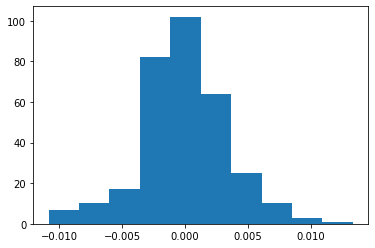

In [11]:
if NNtype != "PSN":
    predictions = model.predict(testloader, mu=testmu, sigma=testsigma)
else:
    predictions = model.predict(testloader, min_=min_, max_=max_)
plt.hist(np.array(predictions))

Text(0.5, 1.0, 'UnNormalized')

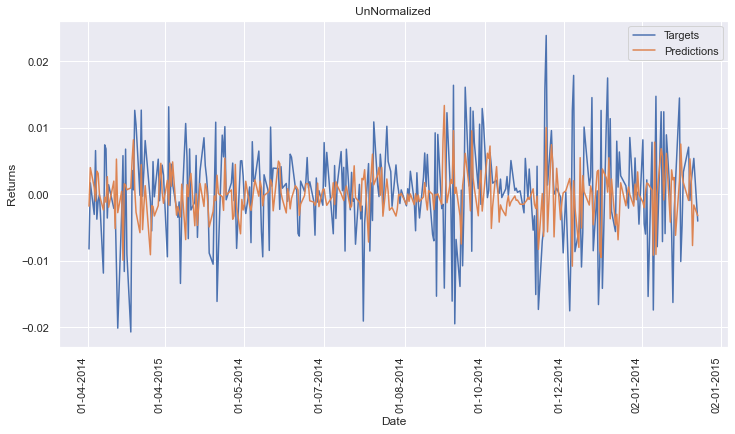

In [13]:
if NNtype == "PSN":
    targets = testdf["Target"]*(max_ - min_) + min_
else :
    targets = testdf["Target"].tolist()

dataDf = pd.DataFrame({'Predictions':predictions, 'Targets':targets})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
ax.set_ylabel('Returns')
ax.set_title("UnNormalized")

## Train and Evaluate All Models

In [50]:
ETF = 'QQQ'
NNtype = 'PSN'

print("="*10 + ETF + " - " + NNtype + "="*10)
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
elif ETF == "QQQ":
    inputs_lag = cfg.QQQfeatures[NNtype]

traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'

if NNtype != "PSN":
    trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
    validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
    testmu, testsigma = testdf.Return.mean(), testdf.Return.std()
    
    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

else:
    max_ = traindf.Return.max()
    min_ = traindf.Return.min()
    traindf = (traindf - min_) / (max_ - min_)
    validdf = (validdf - min_) / (max_ - min_)
    testdf = (testdf - min_) / (max_ - min_)

    trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
    validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
    testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)

model = NN.Model(NNtype)
epochs = 200 if NNtype == "PSN" else 500
model.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            epochs,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )

model.train(trainloader, validloader)

==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:32] Epoch 100/200 - Train Loss : 0.014463 / Val Loss : 0.005774
[01:03] Epoch 200/200 - Train Loss : 0.014175 / Val Loss : 0.006009
Train MAE : 0.0886 | Train MAPE  : 0.1706 | Train RMSE : 0.1172 | Train Theil-U 0.1027
Valid MAE : 0.0611 | Valid MAPE  : 0.1062 | Valid RMSE : 0.0775 | Valid Theil-U 0.0684


Normalized Test MAE : 0.007384 | Test MAPE  : 4027.963181 | Test RMSE : 0.009217 | Test Theil-U 0.774199
Test MAE : 0.007384 | Test MAPE  : 1808722958671.989990 | Test RMSE : 0.009217 | Test Theil-U 0.774199


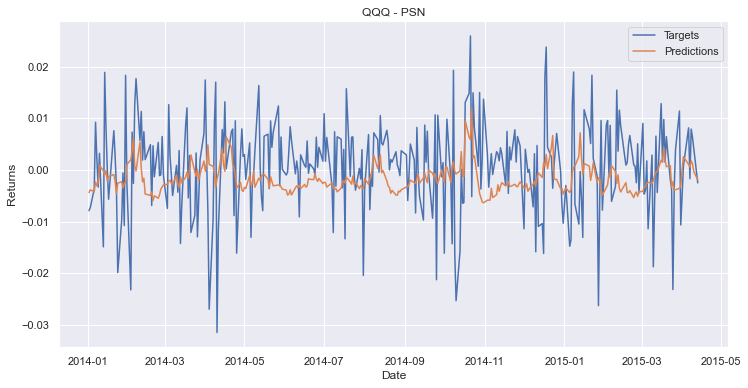

In [51]:
if NNtype == "PSN":
    model.evaluate(testloader, min_=min_, max_=max_)
    preds = model.predict(testloader, min_=min_, max_=max_)
    labels = testdf["Target"]*(max_ - min_) + min_
else :
    model.evaluate(testloader, sigma=testsigma, mu=testmu)
    preds = model.predict(testloader, sigma=testsigma, mu=testmu)
    labels = np.array(testdf["Target"].tolist())

testRMSE = np.sqrt(mean_squared_error(labels, preds))
testMAE = mean_absolute_error(labels, preds)
testMAPE = mean_absolute_percentage_error(labels, preds)
testTheilU = theilU(labels, preds)

print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))

## plot Target and Predictions UnNormalized ##
dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
dataDf.index = testdf.index
dataDf

sns.set()
fig, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

ax.set_ylabel('Returns')
ax.set_title(ETF + " - " + NNtype)
plt.show() 

## Train all Models and create Table4

==========SPY - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.011927 / Val Loss : 0.990674
[00:33] Epoch 100/500 - Train Loss : 0.907809 / Val Loss : 0.999826
[01:05] Epoch 200/500 - Train Loss : 0.850499 / Val Loss : 1.041211
[01:38] Epoch 300/500 - Train Loss : 0.805909 / Val Loss : 1.079332
[02:10] Epoch 400/500 - Train Loss : 0.785614 / Val Loss : 1.106351
[02:43] Epoch 500/500 - Train Loss : 0.775914 / Val Loss : 1.128360
Train MAE : 0.6337 | Train MAPE  : 2.7591 | Train RMSE : 0.8816 | Train Theil-U 0.5878
Valid MAE : 0.8314 | Valid MAPE  : 1.6302 | Valid RMSE : 1.0622 | Valid Theil-U 0.7449
Normalized Test MAE : 0.006125 | Test MAPE  : 2.428605 | Test RMSE : 0.008198 | Test Theil-U 0.754834
Test MAE : 0.613407 | Test M

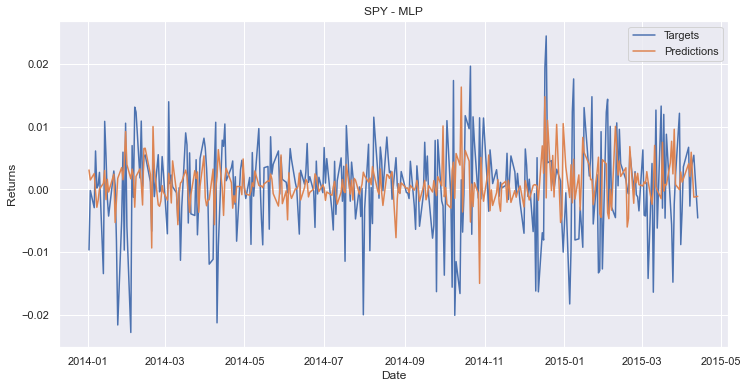




==========SPY - RNN==========
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.030017 / Val Loss : 0.997869
[00:45] Epoch 100/500 - Train Loss : 0.755488 / Val Loss : 1.148597
[01:32] Epoch 200/500 - Train Loss : 0.726679 / Val Loss : 1.206547
[02:19] Epoch 300/500 - Train Loss : 0.722794 / Val Loss : 1.220124
[03:09] Epoch 400/500 - Train Loss : 0.720857 / Val Loss : 1.228865
[03:58] Epoch 500/500 - Train Loss : 0.719659 / Val Loss : 1.236405
Train MAE : 0.6111 | Train MAPE  : 2.2356 | Train RMSE : 0.8297 | Train Theil-U 0.5374
Valid MAE : 0.8566 | Valid MAPE  : 2.0041 | Valid RMSE : 1.1119 | Valid Theil-U 0.7143
Normalized Test MAE : 0.006167 | Test MAPE  : 2.867312 | Test RMSE : 0.008028 | Test Theil-U 0.711063
Test MAE : 0.618026 | Test MAPE  : 2.302594 | Test RMSE : 0.007997 | Test Theil-U 0.7

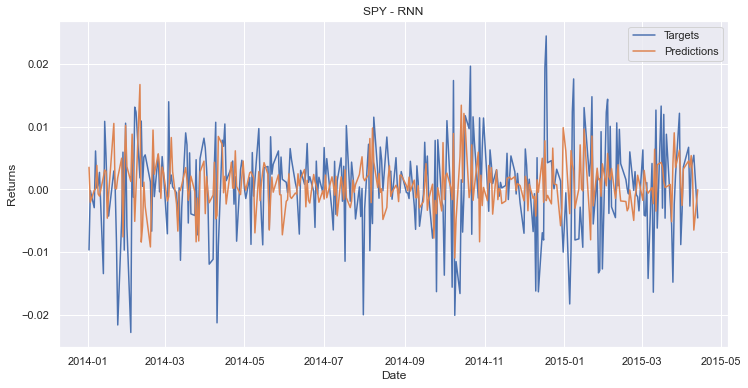




==========SPY - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.013448 / Val Loss : 0.005108
[00:32] Epoch 100/200 - Train Loss : 0.012825 / Val Loss : 0.007506
[01:05] Epoch 200/200 - Train Loss : 0.012613 / Val Loss : 0.007628
Train MAE : 0.0915 | Train MAPE  : 0.1612 | Train RMSE : 0.1197 | Train Theil-U 0.1016
Valid MAE : 0.0745 | Valid MAPE  : 0.1205 | Valid RMSE : 0.0873 | Valid Theil-U 0.0752
Normalized Test MAE : 0.003332 | Test MAPE  : 0.968411 | Test RMSE : 0.003898 | Test Theil-U 0.345556
Test MAE : 0.333185 | Test MAPE  : 0.968410 | Test RMSE : 0.003898 | Test Theil-U 0.345556


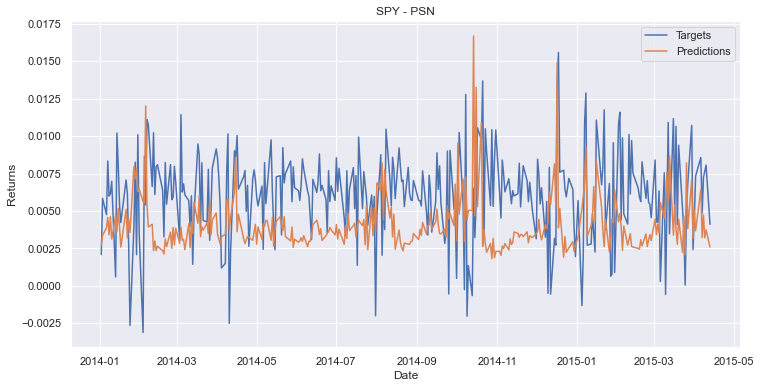




==========DIA - MLP==========
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.003410 / Val Loss : 1.008861
[00:33] Epoch 100/500 - Train Loss : 0.945215 / Val Loss : 1.031868
[01:06] Epoch 200/500 - Train Loss : 0.856203 / Val Loss : 1.091963
[01:40] Epoch 300/500 - Train Loss : 0.765937 / Val Loss : 1.139995
[02:13] Epoch 400/500 - Train Loss : 0.704554 / Val Loss : 1.191197
[02:48] Epoch 500/500 - Train Loss : 0.677821 / Val Loss : 1.258126
Train MAE : 0.6254 | Train MAPE  : 2.5265 | Train RMSE : 0.8078 | Train Theil-U 0.5278
Valid MAE : 0.8693 | Valid MAPE  : 2.4112 | Valid RMSE : 1.1217 | Valid Theil-U 0.7288
Normalized Test MAE : 0.006266 | Test MAPE  : 677.569371 | Test RMSE : 0.008235 | Test Theil-U 0.721136
Test MAE : 0.627992 | T

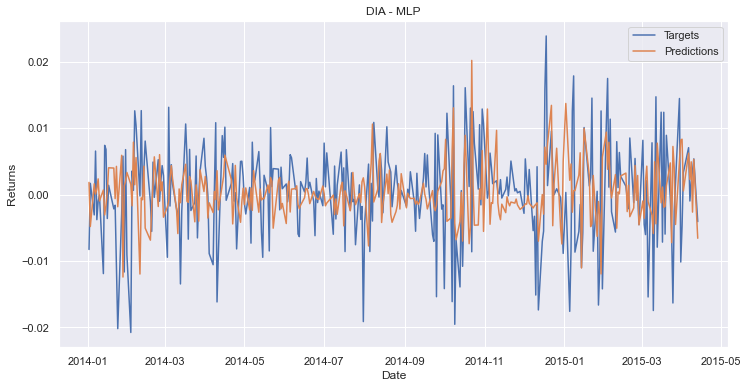




==========DIA - RNN==========
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.073123 / Val Loss : 0.999715
[00:46] Epoch 100/500 - Train Loss : 0.795610 / Val Loss : 1.341757
[01:33] Epoch 200/500 - Train Loss : 0.756389 / Val Loss : 1.354117
[02:25] Epoch 300/500 - Train Loss : 0.740673 / Val Loss : 1.364180
[03:25] Epoch 400/500 - Train Loss : 0.732878 / Val Loss : 1.369504
[04:20] Epoch 500/500 - Train Loss : 0.728125 / Val Loss : 1.372348
Train MAE : 0.6212 | Train MAPE  : 3.5422 | Train RMSE : 0.8307 | Train Theil-U 0.5346
Valid MAE : 0.8950 | Valid MAPE  : 2.5123 | Valid RMSE : 1.1715 | Valid Theil-U 0.7318
Normalized Test MAE : 0.006316 | Test MAPE  : 90.164299 | Test RMSE : 0.008083 | Test Theil-U 0.696190
Test MAE : 0.632980 | Test MAPE  : 2.433937 | Test RMSE : 0.008071 | Test Theil-U 0.

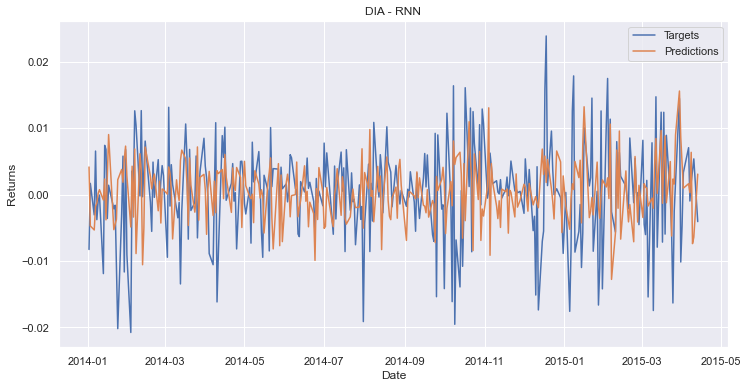




==========DIA - PSN==========
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.020693 / Val Loss : 0.013869
[00:32] Epoch 100/200 - Train Loss : 0.013806 / Val Loss : 0.007054
[01:12] Epoch 200/200 - Train Loss : 0.013737 / Val Loss : 0.007241
Train MAE : 0.0861 | Train MAPE  : 0.1654 | Train RMSE : 0.1170 | Train Theil-U 0.1003
Valid MAE : 0.0702 | Valid MAPE  : 0.1169 | Valid RMSE : 0.0851 | Valid Theil-U 0.0736
Normalized Test MAE : 0.003198 | Test MAPE  : 1.163124 | Test RMSE : 0.003907 | Test Theil-U 0.351409
Test MAE : 0.319830 | Test MAPE  : 1.163123 | Test RMSE : 0.003907 | Test Theil-U 0.351409


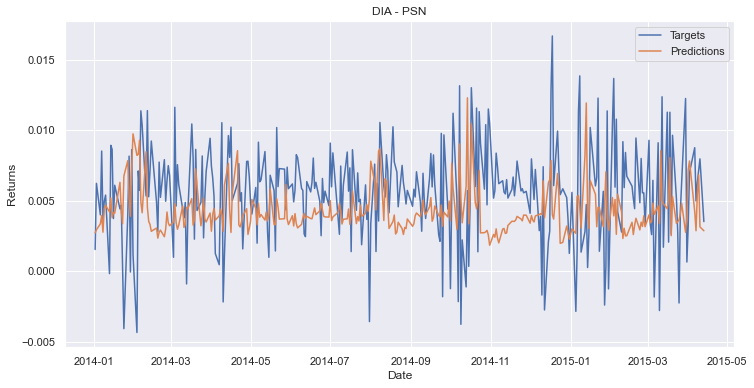




==========QQQ - MLP==========
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.036978 / Val Loss : 1.000179
[00:35] Epoch 100/500 - Train Loss : 0.944007 / Val Loss : 0.978935
[01:08] Epoch 200/500 - Train Loss : 0.782312 / Val Loss : 1.029783
[01:46] Epoch 300/500 - Train Loss : 0.724475 / Val Loss : 1.199849
[02:28] Epoch 400/500 - Train Loss : 0.690259 / Val Loss : 1.246230
[03:10] Epoch 500/500 - Train Loss : 0.662413 / Val Loss : 1.298855
Train MAE : 0.6149 | Train MAPE  : 2.6768 | Train RMSE : 0.7995 | Train Theil-U 0.5020
Valid MAE : 0.8849 | Valid MAPE  : 5.4843 | Valid RMSE : 1.1397 | Valid Theil-U 0.7024
Normalized Test MAE : 0.008244 | Test MAPE  : 5.452808 | Test RMSE : 0.010629 | Test Theil-U 0.759158
Test MAE : 0.835370 | Tes

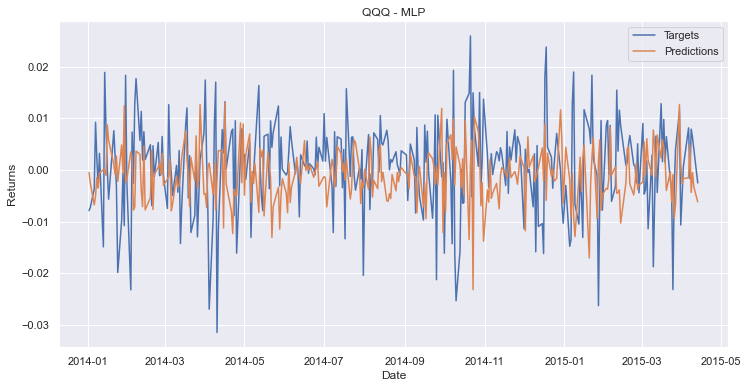




==========QQQ - RNN==========
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/500 - Train Loss : 1.036460 / Val Loss : 1.004007
[01:00] Epoch 100/500 - Train Loss : 0.711504 / Val Loss : 1.301017
[01:54] Epoch 200/500 - Train Loss : 0.640902 / Val Loss : 1.419323
[02:54] Epoch 300/500 - Train Loss : 0.610578 / Val Loss : 1.460580
[03:54] Epoch 400/500 - Train Loss : 0.598209 / Val Loss : 1.478942
[04:53] Epoch 500/500 - Train Loss : 0.587594 / Val Loss : 1.491868
Train MAE : 0.5945 | Train MAPE  : 3.0823 | Train RMSE : 0.7490 | Train Theil-U 0.4516
Valid MAE : 0.9204 | Valid MAPE  : 3.5079 | Valid RMSE : 1.2214 | Valid Theil-U 0.7266
Normalized Test MAE : 0.008298 | Test MAPE  : 5.915392 | Test RMSE : 0.011176 | Test Theil-U 0.740233
Test MAE : 0.833981 | Test MAPE  : 3.389910 | Test RMSE : 0.011204 | Test Theil-U 0

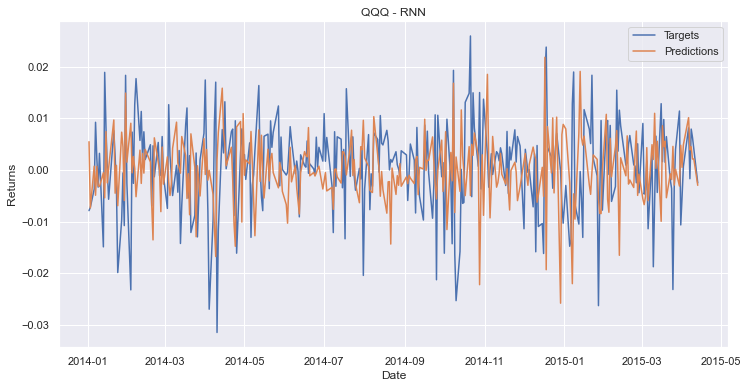




==========QQQ - PSN==========
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
[00:00] Epoch 1/200 - Train Loss : 0.018489 / Val Loss : 0.011347
[00:39] Epoch 100/200 - Train Loss : 0.014346 / Val Loss : 0.005779
[01:20] Epoch 200/200 - Train Loss : 0.014255 / Val Loss : 0.006036
Train MAE : 0.0886 | Train MAPE  : 0.1705 | Train RMSE : 0.1176 | Train Theil-U 0.1031
Valid MAE : 0.0615 | Valid MAPE  : 0.1067 | Valid RMSE : 0.0777 | Valid Theil-U 0.0686
Normalized Test MAE : 0.003021 | Test MAPE  : 2.282329 | Test RMSE : 0.003760 | Test Theil-U 0.369820
Test MAE : 0.302130 | Test MAPE  : 2.282352 | Test RMSE : 0.003760 | Test Theil-U 0.369820


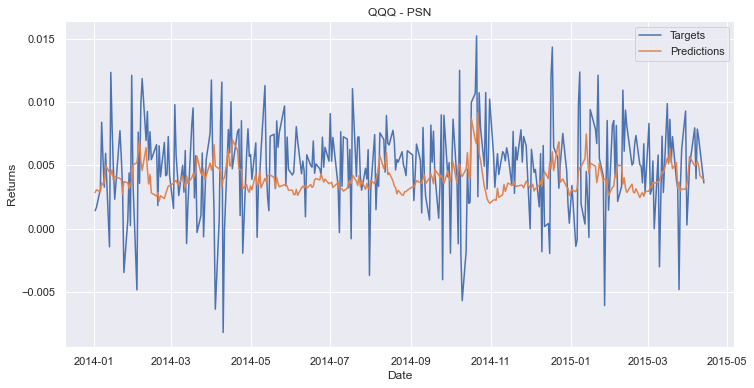

In [52]:
Table4 = pd.DataFrame()

models = {'SPY':{'MLP':None,'RNN':None,'PSN':None},
          'DIA':{'MLP':None,'RNN':None,'PSN':None},
          'QQQ':{'MLP':None,'RNN':None,'PSN':None},
         }

for ETF in ['SPY', 'DIA', 'QQQ']:
    
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        print("="*10 + ETF + " - " + NNtype + "="*10)
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        elif ETF == "QQQ":
            inputs_lag = cfg.QQQfeatures[NNtype]

        traindf = utils.load_file(os.path.join("data", ETF, NNtype, "Train.pkl"))
        validdf = utils.load_file(os.path.join("data", ETF, NNtype, "Valid.pkl"))
        testdf  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        if NNtype != "PSN":
            trainmu, trainsigma = traindf.Return.mean(), traindf.Return.std()
            validmu, validsigma = validdf.Return.mean(), validdf.Return.std()
            testmu, testsigma = testdf.Return.mean(), testdf.Return.std()

            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=True, mu=trainmu, sigma=trainsigma)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=True, mu=validmu, sigma=validsigma)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=True, mu=testmu, sigma=testsigma)

        else:
            max_ = traindf.Return.max()
            min_ = traindf.Return.min()
            
            traindf = (traindf - min_) / (max_ - min_)
            validdf = (validdf - min_) / (max_ - min_)
            testdf = (testdf - min_) / (max_ - min_)
            
            trainloader = utils.DataFrame2DataLoader(traindf, features_col, target_col, batch_size=1, normalize=False)
            validloader = utils.DataFrame2DataLoader(validdf, features_col, target_col, batch_size=1, normalize=False)
            testloader  = utils.DataFrame2DataLoader(testdf, features_col, target_col, batch_size=1, normalize=False)
            
            
        model = NN.Model(NNtype)
        epochs = 200 if NNtype == "PSN" else 500
        model.setup(params["input_size"], 
                    params["hidden_size"],
                    params["output_size"],
                    epochs,#params["epochs"],
                    params["optim"],
                    params["lr"],
                    params["momentum"]
                   )

        model.train(trainloader, validloader)
        
        if NNtype == "PSN":
            model.evaluate(testloader, min_=testMin_, max_=testMax_)
            preds = model.predict(testloader, min_=testMin_, max_=testMax_)
            labels = testdf["Target"]*(testMax_ - testMin_) + testMin_
        else :
            model.evaluate(testloader, sigma=testsigma, mu=testmu)
            preds = model.predict(testloader, sigma=testsigma, mu=testmu)
            labels = np.array(testdf["Target"].tolist())
        
        testRMSE = np.sqrt(mean_squared_error(labels, preds))
        testMAE = 100*mean_absolute_error(labels, preds)
        testMAPE = mean_absolute_percentage_error(labels, preds)
        testTheilU = theilU(labels, preds)

        print("Test MAE : {:.6f} | Test MAPE  : {:.6f} | Test RMSE : {:.6f} | Test Theil-U {:.6f}".format(testMAE, testMAPE, testRMSE, testTheilU))
        
        ## plot Target and Predictions UnNormalized ##
        dataDf = pd.DataFrame({'Predictions':preds, 'Targets':labels})
        dataDf.index = testdf.index
        
        sns.set()
        fig, ax = plt.subplots(figsize = (12,6))
        sns.lineplot(x=dataDf.index, y='Targets', data=dataDf, label="Targets")
        sns.lineplot(x=dataDf.index, y='Predictions', data=dataDf, label="Predictions")

#         x_dates = dataDf.index.strftime('%d-%m-%Y').sort_values().unique()
#         ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');
        ax.set_ylabel('Returns')
        ax.set_title(ETF + " - " + NNtype)
        plt.show()
        
        models[ETF][NNtype] = model
        
        Table[NNtype] = [testMAE, testMAPE, testRMSE, testTheilU]
        Table["ETF"] = ETF 
        print("\n"*2)
     
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True) 

### Save Models

In [55]:
for ETF in ["SPY", "DIA", "QQQ"]:
    for NNtype in ["MLP", "RNN", "PSN"]:
        os.makedirs(os.path.join("models_norm", ETF, NNtype), exist_ok=True)
        save_model(models[ETF][NNtype].model.state_dict(), os.path.join("models_norm", ETF, NNtype, "ckpt.pth"))

### Load Ckpt

In [43]:
ETF = "DIA"
NNtype = "MLP"
params = cfg.train_parameters[ETF][NNtype]
inputs_lag = cfg.DIAfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"], 
            params["hidden_size"],
            params["output_size"],
            1000,#params["epochs"],
            params["optim"],
            params["lr"],
            params["momentum"]
           )
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005390 | Test MAPE  : 1.079670 | Test RMSE : 0.007245 | Test Theil-U 0.926919


# To work

# Generating Table 4

In [ ]:
Table4 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Statistic":["MAE", "MAPE", "RMSE", "THEIL-U"]})
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=8, normalize=False)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader)
        
        Table[NNtype] = [modelloaded.testMAE, modelloaded.testMAPE, modelloaded.testRMSE, modelloaded.testTheilU]
        Table["ETF"] = ETF
    
    Table4 = pd.concat([Table4,Table],ignore_index=True)

Table4.set_index(["ETF"], inplace=True)    
Table4.to_csv("table/Table4norm.csv", index=True)        

In [10]:
ypred, ytrue, evaluation = modelloaded.Getevaluation(dataloader)

In [14]:
import numpy as np
y_pred = np.array(ypred)
y_true = np.array(ytrue)

In [51]:
modelloaded.evaluate(dataloader)

Test MAE : 0.005624 | Test MAPE  : inf | Test RSME : 0.000054 | Test Theil-U 0.769070


In [20]:
np.abs((y_true - y_pred)/y_true)

array([5.97504411e-01, 8.19620566e-01, 7.61992324e-01, 1.27961111e+00,
       1.55741931e+00, 1.06965293e+00, 4.08921429e+01, 1.03007374e+00,
       1.17004060e+00, 7.15264093e-01, 6.79977365e-01, 1.38981662e+00,
       5.70637783e-01, 2.21547445e+00, 1.06259083e+00, 8.27917005e-01,
       1.34271908e+00, 1.28133038e+00, 9.69783017e-01, 6.09123871e-01,
       1.31316356e+00, 1.12362061e+00, 4.03105552e-01, 3.35606941e+00,
       7.98431427e-01, 6.87432206e-01, 7.31159248e-01, 3.80845850e-01,
       1.51305376e+00, 1.29509997e+00, 7.20141230e-01, 3.29434595e+00,
       1.13785257e+00, 1.49065573e+00, 3.72291052e+00, 7.72002016e-01,
       6.24651569e-01, 8.43269646e-01, 5.24755104e-01, 1.34105122e+00,
       1.07121130e+00, 9.88006366e-01, 8.68172943e-01, 1.04517050e+00,
       3.42294065e-01, 4.86738036e-01, 1.53935203e+00, 2.25559896e-01,
       8.57544100e-01, 1.52026479e+00, 1.25801378e+00, 6.77532215e-01,
       1.29784225e+00, 7.91556409e-01, 2.08852883e+00, 1.93345424e+00,
      

In [30]:
y_true[y_true == 0] = 0.000006

In [31]:
np.where(y_true == 0)

(array([], dtype=int64),)

In [12]:
Table4

NameError: name 'Table4' is not defined